# Chen Identity Verification Example

This notebook demonstrates the Chen identity for path signatures by:
1. Splitting a path into 4 segments using augmentations
2. Computing signatures for each segment  
3. Concatenating them using the @ operator (Chen identity)
4. Comparing with the signature of the whole path

The Chen identity states that the signature of a concatenated path equals the product of the signatures of the individual segments.

First, lets compute a standard Brownian motion with `bm_driver` to act as our example path, and split it into fixed size windows using `non_overlapping_windower`

range(0, 8)
range(8, 16)
range(16, 24)
range(24, 32)


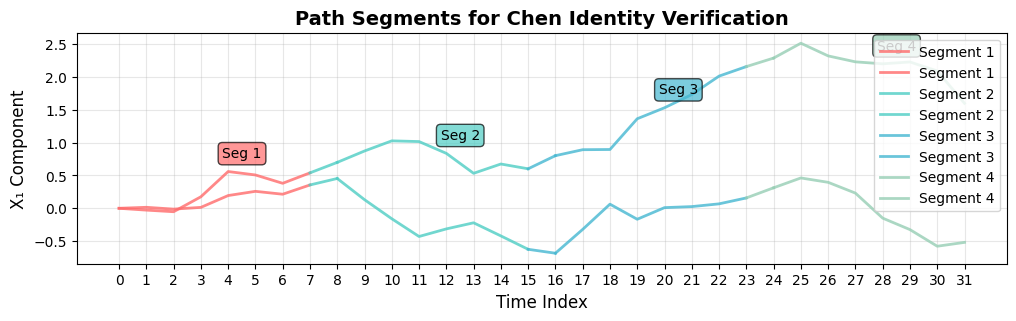

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from quicksig.rdes.drivers import bm_driver
from quicksig.rdes.augmentations import non_overlapping_windower

brownian_motion = bm_driver(jax.random.key(1), 32, 2)
windows = non_overlapping_windower(brownian_motion, 8)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#2C3E50']  # Added dark blue for whole path
for i, segment in enumerate(windows):
    # Create indices for this specific segment
    start_idx = int(segment.interval[0])
    end_idx   = int(segment.interval[1])
    indices = range(start_idx, end_idx)
    print(indices)

    # Plot the segment
    plt.plot(indices, segment.path[:, :], color=colors[i], linewidth=2,
             label=f'Segment {i+1}', alpha=0.8)

    # --- NEW: draw connector from previous segment end to current start for all path dims
    if i > 0:
        prev = windows[i-1]
        for d in range(segment.path.shape[1]):
            plt.plot([start_idx - 1, start_idx],
                     [float(prev.path[-1, d]), float(segment.path[0, d])],
                     color=colors[i], linewidth=2, alpha=0.8)

    # Add segment annotation
    mid_idx = (start_idx + end_idx) // 2
    plt.annotate(f'Seg {i+1}',
                 xy=(mid_idx, float(segment.path[mid_idx - start_idx, 0])),
                 xytext=(10, 10), textcoords='offset points',
                 bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[i], alpha=0.7),
                 fontsize=10, ha='center')

plt.title('Path Segments for Chen Identity Verification', fontsize=14, fontweight='bold')
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('X₁ Component', fontsize=12)
plt.xticks(np.arange(brownian_motion.path.shape[0]))
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.gcf().set_size_inches(12, 3)


In [2]:
from quicksig.signatures.compute_path_signature import compute_path_signature

signatures = [compute_path_signature(window.path, 3, "full") for window in windows]
print(signatures[2])

Signature(
    depth=3,
    ambient_dimension=2,
    interval=(0, 8),
    signature_shapes=[(2,), (2, 2), (2, 2, 2)]
)


Let's also note that its possible to concatenate the paths themselves. This will also check for interval continuity, etc.

In [3]:
concat_path = windows[0] + windows[1] + windows[2] + windows[3]

print(brownian_motion == concat_path)
# print("Success. The concatenated path is equal to the original path.")

False


In [7]:
print(concat_path)
print(brownian_motion
)

Path(
    interval=(0, 32),
    num_timesteps=32,
    ambient_dimension=2,
    path_shape=(32, 2)
)
Path(
    interval=(0, 31),
    num_timesteps=32,
    ambient_dimension=2,
    path_shape=(32, 2)
)
